- 평점 데이터 내의 사용자 정보를 기준으로 정보를 취합하고 현황을 파악한다.
- 사용자 별로 몇편의 영화에 평점을 부여했는지 분포를 파악하라(histogram)
- 사용자의 활동 패턴(활동 기간, 평점 주기 패턴)을 탐색하라(linear chart)
- 사용자의 선호 장르를 파악할 수 있게 시각화 하라(heatmap)

### 수행 방법
- 결측치를 파악후 제거 또는 채운다.
- x축: 사용자 id y축: 영화 평점 편수
- date column을 추가 후 가로축을 시간, 세로축을 평점으로 한 lienar chat를 그린다.
- bar chart, histogram, linear chart, heatmap을 그리는 방법을 파악하고 함수화 한다.

### 평가 기준
- 사용자별 장르 구분이 되는 차트 표현했는가?
- 사용자 수 변경하며 확인할 수 있는가?
- 데이터 수치차이가 크다면 적절하게 크기 조정 했는가?
- 1인당 최소 몇 편은 평점이 있어야 하는가?
- 해당하는 평점 데이터는 전체에서 몇퍼센트인가?
- 사용자의 활동 기간 및 활동 패턴(예: 주말)을 파악할 수 있는가?
- 사용자들이 공통으로 많이 보는 장르를 특정할 수 있는가?

In [2]:
# module
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

In [3]:
# Util Functions
from enum import Enum

# 파일을 읽어와 pandas의 DataFrame으로 반환해줌
def get_df_from(path: str, sep: str = ','):
    extension = path.split('.')[-1]
    try:
        if extension == "csv" or extension == "txt":
            df = pd.read_csv(path, sep=sep, on_bad_lines='skip')
            if df.empty:
                print("W: DataFrame is empty.")
                return None
            return df
        else:
            print("E: File extension is not supported.")
            return None
    except FileNotFoundError:
        print(f"E: File not found. Check the path: {path}")
        return None
    except pd.errors.ParserError as e:
        print(f"E: Error parsing CSV file: {e}")
        return None
    except Exception as e:
        print(f"E: An unexpected error occured: {e}")
        return None

# 리스트의 평균을 반환.(기본값 0)
def calculate_mean(lst):
    if lst: # 빈 리스트가 아닌 경우에만 평균 계산
        return np.mean(lst)
    return 0 # 빈 리스트인 경우 NaN 반환

# 리스트의 합을 반환.(기본값 0)
def calculate_sum(lst):
    if lst:
        return np.sum(lst)
    return 0


class ChartShape(Enum):
    BAR = 1
    HISTOGRAM = 2
    LINE = 3
    HEATMAP = 4

# Chart 뽑는 함수
def get_chart_from(df: pd.DataFrame, x_col: str, y_col: str, shape: ChartShape = ChartShape.BAR, real_time: bool = False):
    plt.figure(figsize=(10, 6))
    if shape == ChartShape.BAR:
        plt.bar(df[x_col], df[y_col])
    elif shape == ChartShape.HISTOGRAM:
        plt.hist(df[x_col], bins=10)
    elif shape == ChartShape.LINE:
        plt.plot(df[x_col], df[y_col])
    else:
        plt.plot(df[x_col], df[y_col])

    if real_time:
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator()) # 월 단위로 큰 눈금 표시
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # 날짜 형식 지정
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(df[x_col], rotation=45, ha='right')
    plt.show()

def get_chart_from_series(sr: pd.Series, x_col: str, y_col: str, shape: ChartShape = ChartShape.BAR):
    if shape == ChartShape.BAR:
        sr.plot.bar()
    if shape == ChartShape.LINE:
        sr.plot.line()
    if shape == ChartShape.HISTOGRAM:
        sr.plot.hist()
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.show()

def get_integer(question: str):
    try:
        id = int(input(question))
        return id
    except:
        print(f"E: invalid integer")
        return 0

In [4]:
# Function

def get_df_strict_from(path: str, sep: str = ','):
    df = get_df_from(path, sep)
    for _ in range(3):
        if df is not None:
            return df
        new_path = input('오류가 발생했습니다. 정확한 경로를 확인해주세요: ')
        new_sep = input('구분자를 입력해주세요: ')
        df = get_df_from(new_path, new_sep)
    exit()

In [5]:
rates_path = './kmrd-small/rates.csv'
genres_path = './kmrd-small/genres.csv'

rates_df = get_df_strict_from(rates_path)
genres_df = get_df_strict_from(genres_path)

In [6]:
genres_df_groupby = pd.DataFrame(genres_df.groupby('movie')['genre'].apply(list))
genres_df_groupby.columns = ['genre']
rates_df_merge = pd.merge(rates_df, genres_df_groupby, how='left', left_on='movie', right_index=True)
rates_count = rates_df_merge.value_counts('user')

print(f"평점을 부여한 사용자 수는 총 {len(rates_count)} 명 입니다.")
print(f"평점을 가장 많이 부여한 사용자는 {rates_count.idxmax()}번 이며 {rates_count.max()}편 평가했습니다.")
print(f"평점을 10개 미만으로 부여한 사용자는 {rates_count[rates_count < 10].size}명이다.")

# 평점 5개 미만 사용자는 활용하기 어려울 것.
n = 5
rates_over_n = rates_count[rates_count >= n].sum()
rates_all = rates_count.sum()
print(f"평점을 5개 이상으로 부여해 사용할만한 데이터는 {rates_over_n}편이며 전체의 {round((rates_over_n / rates_all) * 100, 2)}%다.")

평점을 부여한 사용자 수는 총 52028 명 입니다.
평점을 가장 많이 부여한 사용자는 465번 이며 413편 평가했습니다.
평점을 10개 미만으로 부여한 사용자는 49887명이다.
평점을 5개 이상으로 부여해 사용할만한 데이터는 76184편이며 전체의 54.14%다.


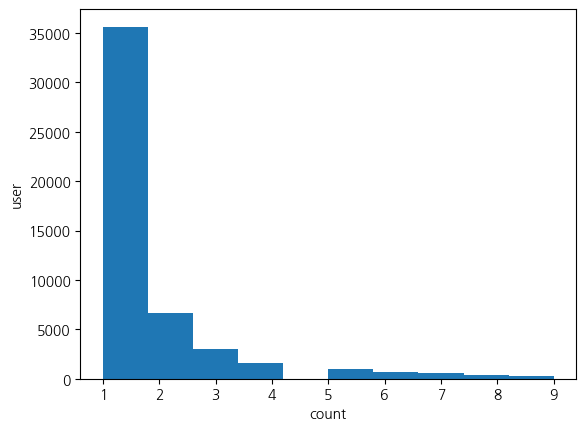

In [7]:
count = get_integer("최대 편수를 입력하세요: ") # 10
get_chart_from_series(rates_count[rates_count < count], "count", "user", ChartShape.HISTOGRAM)

In [8]:
import datetime

def get_user_pattern_chart(id: int):
    filtered_user = rates_df[rates_df['user'] == id]
    if not filtered_user.empty :
        filtered_user = filtered_user.sort_values(by='timestamp')
        get_chart_from(filtered_user, 'timestamp', 'rate', shape=ChartShape.LINE, real_time=True)
        get_chart_from_series(filtered_user.groupby('hour').size(), 'hour', 'count')
        get_chart_from_series(filtered_user.groupby('요일').size().reindex(['월', '화', '수', '목', '금', '토', '일']), '요일', 'count')
    else:
        print("E: Invalid user ID!")

rates_df['timestamp'] = pd.to_datetime(rates_df['time'], unit='s')

day_map = {0: '월', 1: '화', 2: '수', 3: '목', 4: '금', 5: '토', 6: '일'}
rates_df['hour'] = rates_df['timestamp'].dt.hour
rates_df['dayofweek'] = rates_df['timestamp'].dt.day_of_week
rates_df['요일'] = rates_df['dayofweek'].map(day_map)

In [49]:
merge_df = pd.merge(rates_df, genres_df, how='left')
grouped = merge_df.groupby(['user', 'genre']).size().reset_index(name='count')
grouped['log_count'] = np.log(grouped['count'])
grouped['log_count'] = grouped['log_count'].apply(lambda x: max(x, 0.3))
sample1 = grouped.pivot_table(index='user', columns='genre', values='log_count')

# merge_df['test'] = 1
# sample1 = merge_df.pivot_table(index='user', columns='genre', values='test', aggfunc=lambda x: np.log10(sum(x)))
sample1 = sample1.fillna(0)
print(sample1.head(10))
def get_user_genre_heatmap(s_val: int):
    e_val = s_val + 21
    data = sample1[s_val:e_val] / 10 * 3.5

    plt.figure(figsize=(8, 6))  # 그래프 크기 설정 (선택적)
    plt.imshow(
        data, cmap="magma", interpolation="nearest", aspect="auto"
    )  # 히트맵 그리기

    plt.colorbar(label="Value")  # 컬러바 추가
    plt.title("Heatmap using imshow()")

    plt.xticks(ticks=np.arange(len(data.columns)), labels=data.columns, rotation=90)
    plt.yticks(ticks=np.arange(0, 21), labels=np.arange(s_val, e_val))

    plt.gca().set_facecolor('black')

    plt.tight_layout()
    plt.show()


genre        SF        가족        공포       느와르  다큐멘터리       드라마    멜로/로맨스  \
user                                                                       
0      2.397895  1.098612  1.386294  0.693147    0.0  4.094345  2.944439   
1      0.000000  0.000000  0.000000  0.000000    0.0  0.300000  0.000000   
2      1.386294  0.000000  1.609438  0.000000    0.0  1.945910  1.098612   
3      2.397895  0.300000  1.791759  0.000000    0.0  4.025352  3.044522   
4      1.945910  0.693147  2.639057  1.386294    0.0  3.761200  2.484907   
5      0.000000  0.000000  0.000000  0.000000    0.0  0.300000  0.000000   
6      0.300000  0.300000  0.300000  0.000000    0.0  1.386294  0.300000   
7      0.300000  0.000000  0.000000  0.000000    0.0  0.693147  1.098612   
8      1.098612  0.300000  0.000000  1.098612    0.0  2.079442  0.693147   
9      0.000000  0.000000  0.300000  0.693147    0.0  2.833213  1.945910   

genre        모험       뮤지컬      미스터리        범죄        서부   서사       스릴러  애니메이션  \
user  

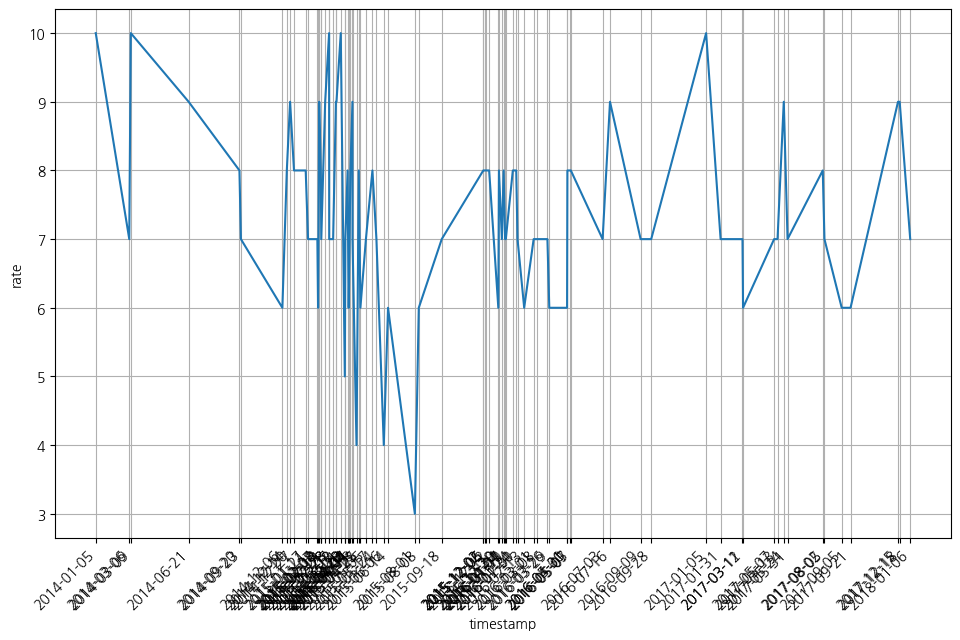

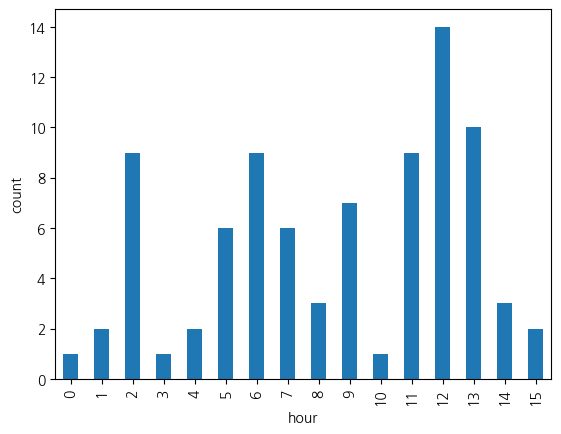

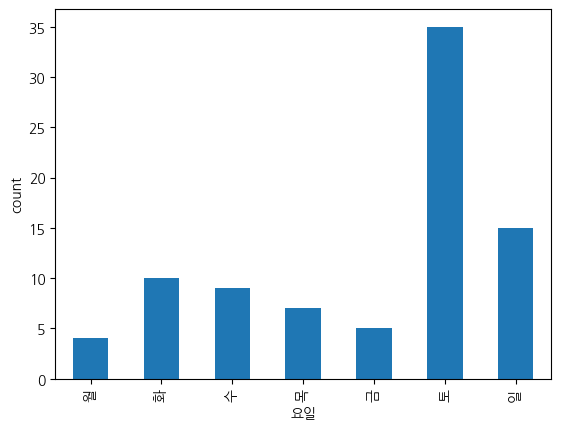

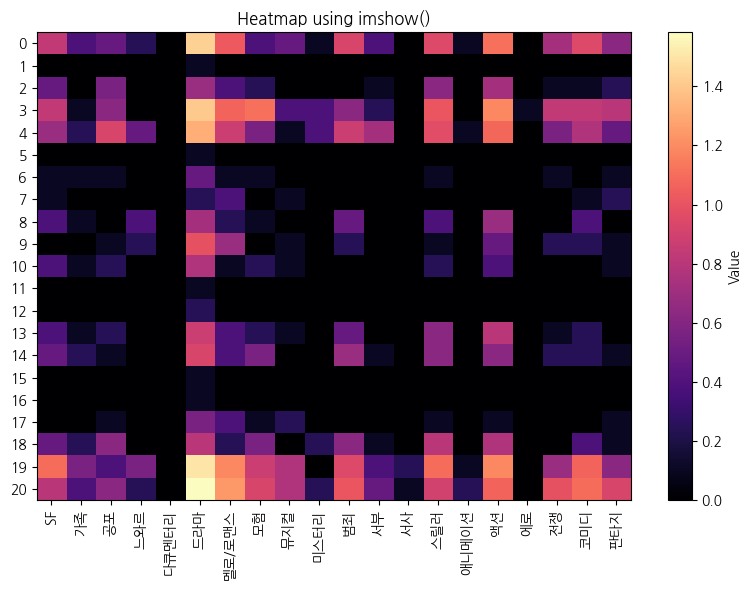

In [50]:
id = get_integer("검색할 유저의 ID를 입력하세요:")

get_user_pattern_chart(id)
get_user_genre_heatmap(id)